# MNIST Image Classification with CNN, MLflow & Data Augmentation
We load images from folders, preprocess them, train a CNN with Keras using data augmentation, and track everything with MLflow.

## 1. Imports and Setup

In [274]:
import collections
import logging
import os
import random

import absl.logging
import matplotlib.pyplot as plt
import mlflow.tensorflow
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
)
from tensorflow.keras.utils import to_categorical

absl.logging.set_verbosity("error")
logging.getLogger("absl").setLevel(logging.ERROR)

IMG_SIZE = 28
BATCH_SIZE = 64
EPOCHS = 40
RANDOM_SEED = 42

## 2. Load and Preprocess Data from Folder

In [275]:
def load_data(folder):
    X, y = [], []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            label = int(filename.split("_")[0])
            img = load_img(
                os.path.join(folder, filename),
                color_mode="grayscale",
                target_size=(IMG_SIZE, IMG_SIZE),
            )
            X.append(img_to_array(img) / 255.0)
            y.append(label)
    return np.array(X), to_categorical(np.array(y), num_classes=10)


X_train, y_train = load_data("data/training")
X_test, y_test = load_data("data/testing")

## 3. Visualize a Sample

In [276]:
print(X_train[0])

[[[0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]]

 [[0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]]

 [[0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.00392157]
  [0.0

In [277]:
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


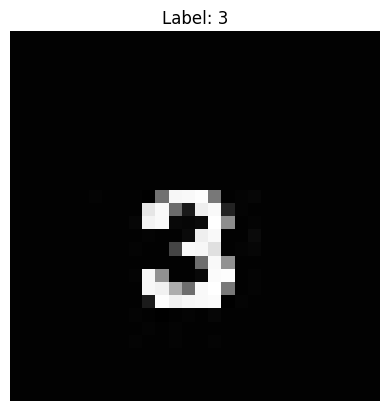

In [278]:
plt.imshow(X_train[0].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
plt.title(f"Label: {np.argmax(y_train[0])}")
plt.axis("off")
plt.show()

## 4. Data Exploration

In [279]:
labels = np.argmax(y_train, axis=1)
print(collections.Counter(labels))

Counter({np.int64(8): 103, np.int64(5): 85, np.int64(3): 83, np.int64(6): 82, np.int64(4): 80, np.int64(7): 80, np.int64(9): 77, np.int64(0): 72, np.int64(2): 72, np.int64(1): 66})


In [280]:
print(np.min(X_train), np.max(X_train))  # should be ~0.0 to ~1.0
print(np.any(np.isnan(X_train)))  # should be False

0.0 1.0
False


## 5. Train/Validation Split

In [281]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_SEED
)

## 6. Data Augmentation

In [282]:
datagen = ImageDataGenerator(
    rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1
)
datagen.fit(X_train)

## 7. Learning Rate Reduction and Early Stopping

In [283]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.00001
)

In [284]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

## 8. Define and Train Model with MLflow Tracking

In [285]:
mlflow.tensorflow.autolog()
with mlflow.start_run():
    model = Sequential(
        [
            Conv2D(
                64,
                (3, 3),
                activation="relu",
                padding="same",
                input_shape=(IMG_SIZE, IMG_SIZE, 1),
            ),
            Conv2D(64, (3, 3), activation="relu", padding="same"),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            Conv2D(128, (3, 3), activation="relu", padding="same"),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Flatten(),
            Dense(512, activation="relu"),
            Dropout(0.5),
            Dense(10, activation="softmax"),
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    history = model.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[learning_rate_reduction, early_stop],
        verbose=2,
    )

    model.evaluate(X_test, y_test, verbose=0)
    model.save("mnist_model.keras")

2025/04/17 03:16:20 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


Epoch 1/40
12/12 - 2s - 147ms/step - accuracy: 0.1028 - loss: 2.3209 - val_accuracy: 0.1500 - val_loss: 2.2998 - learning_rate: 1.0000e-03
Epoch 2/40
12/12 - 1s - 88ms/step - accuracy: 0.1222 - loss: 2.3006 - val_accuracy: 0.1375 - val_loss: 2.2995 - learning_rate: 1.0000e-03
Epoch 3/40
12/12 - 1s - 90ms/step - accuracy: 0.1194 - loss: 2.2980 - val_accuracy: 0.1500 - val_loss: 2.2969 - learning_rate: 1.0000e-03
Epoch 4/40

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
12/12 - 1s - 100ms/step - accuracy: 0.1278 - loss: 2.2835 - val_accuracy: 0.1500 - val_loss: 2.2734 - learning_rate: 1.0000e-03
Epoch 5/40
12/12 - 1s - 109ms/step - accuracy: 0.1208 - loss: 2.2493 - val_accuracy: 0.1875 - val_loss: 2.2487 - learning_rate: 5.0000e-04
Epoch 6/40
12/12 - 1s - 104ms/step - accuracy: 0.1597 - loss: 2.2181 - val_accuracy: 0.1750 - val_loss: 2.2588 - learning_rate: 5.0000e-04
Epoch 7/40
12/12 - 1s - 86ms/step - accuracy: 0.2000 - loss: 2.1652 - val_accuracy: 0.2125 

## 9. Plot Training History

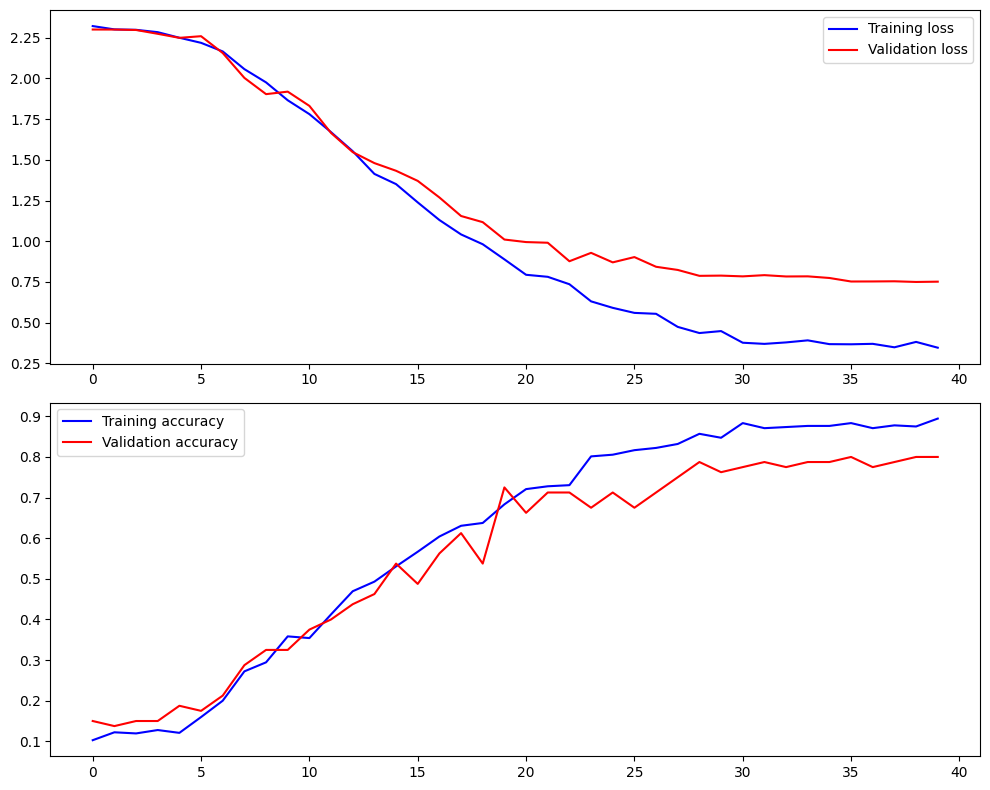

In [286]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(history.history["loss"], color="b", label="Training loss")
ax[0].plot(history.history["val_loss"], color="r", label="Validation loss")
ax[0].legend(loc="best")

ax[1].plot(history.history["accuracy"], color="b", label="Training accuracy")
ax[1].plot(history.history["val_accuracy"], color="r", label="Validation accuracy")
ax[1].legend(loc="best")

plt.tight_layout()
plt.show()

## 9. Evaluate Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Sample 1: Predicted = 1, True = 1
Sample 2: Predicted = 6, True = 5
Sample 3: Predicted = 9, True = 9
Sample 4: Predicted = 1, True = 1
Sample 5: Predicted = 5, True = 5


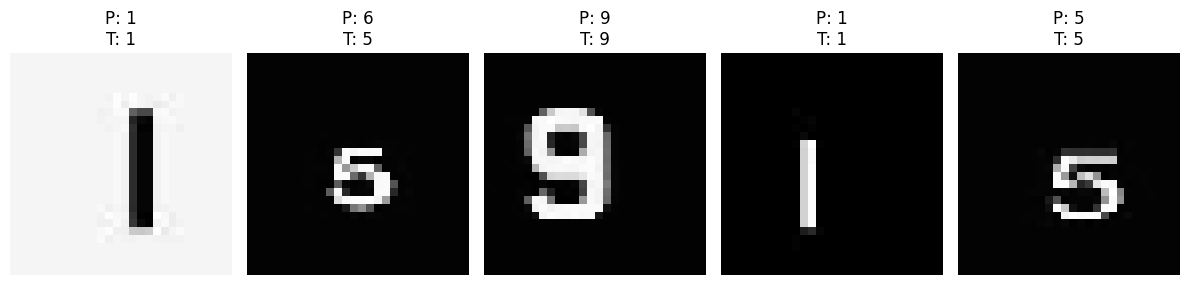

In [287]:
samples = X_test[:5]
true_labels = np.argmax(y_test[:5], axis=1)

# Run model prediction
predictions = model.predict(samples)
predicted_labels = np.argmax(predictions, axis=1)

# Print predicted vs true labels
for i in range(len(samples)):
    print(f"Sample {i + 1}: Predicted = {predicted_labels[i]}, True = {true_labels[i]}")

# Show images with prediction and true label
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i].reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.title(f"P: {predicted_labels[i]}\nT: {true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()